<a href="https://colab.research.google.com/github/ReemAlsharabi/CryptoRobustTraining/blob/main/code/encrypted/encrypted_cifar10_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from torchvision import models,transforms

from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [2]:
pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00


## Data Prep

In [3]:
batch_sz = 64
key = 150 # encryption key

def encrypt_image(image, key):
    # Convert the image to integers between 0 and 255
    image = (image * 255).int()
    # XOR the image with the key
    encrypted_image = image ^ key
    # Convert the encrypted image back to floating-point values between 0 and 1
    encrypted_image = encrypted_image.float() / 255
    return encrypted_image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: encrypt_image(x, key))
])

train_dataset = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 73992586.80it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


In [4]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [5]:
device = get_default_device()
device

device(type='cuda')

In [6]:
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

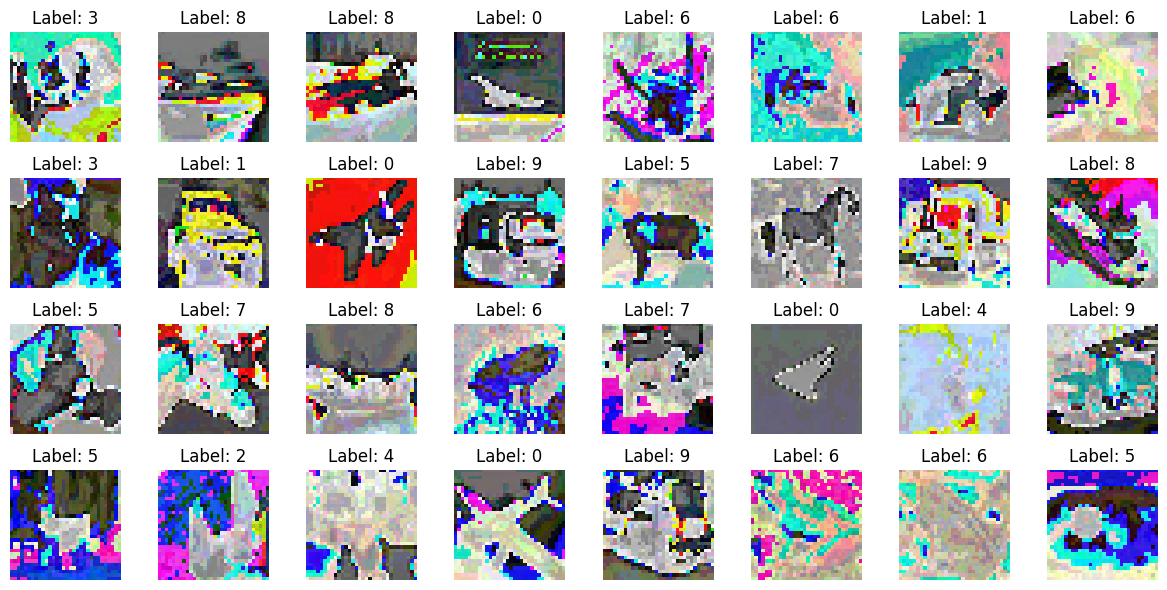

In [8]:
# Load a batch of encrypted images from the test set
data_iter = iter(test_loader)
images, labels = next(data_iter)

images_cpu = [image.cpu() for image in images]

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images_cpu[i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f'Label: {labels[i]}')

plt.tight_layout()
plt.show()

## Model

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [10]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input


In [11]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_loader:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([64, 3, 32, 32])


In [12]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [13]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
history = [evaluate(model, test_loader)]
history

[{'val_loss': 2.30391263961792, 'val_acc': 0.09982085973024368}]

In [16]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [17]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, test_loader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00280, train_loss: 1.4202, val_loss: 2.2091, val_acc: 0.3852
Epoch [1], last_lr: 0.00760, train_loss: 1.2409, val_loss: 2.7831, val_acc: 0.3694
Epoch [2], last_lr: 0.01000, train_loss: 1.0221, val_loss: 1.3429, val_acc: 0.5231
Epoch [3], last_lr: 0.00950, train_loss: 0.9357, val_loss: 1.0850, val_acc: 0.6244
Epoch [4], last_lr: 0.00812, train_loss: 0.8899, val_loss: 1.0526, val_acc: 0.6456
Epoch [5], last_lr: 0.00611, train_loss: 0.8257, val_loss: 1.1686, val_acc: 0.6097
Epoch [6], last_lr: 0.00389, train_loss: 0.7231, val_loss: 0.7851, val_acc: 0.7282
Epoch [7], last_lr: 0.00188, train_loss: 0.5552, val_loss: 0.7217, val_acc: 0.7495
Epoch [8], last_lr: 0.00050, train_loss: 0.3183, val_loss: 0.6399, val_acc: 0.7882
Epoch [9], last_lr: 0.00000, train_loss: 0.1420, val_loss: 0.6371, val_acc: 0.7913
CPU times: user 4min 38s, sys: 1.18 s, total: 4min 39s
Wall time: 4min 41s


In [18]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

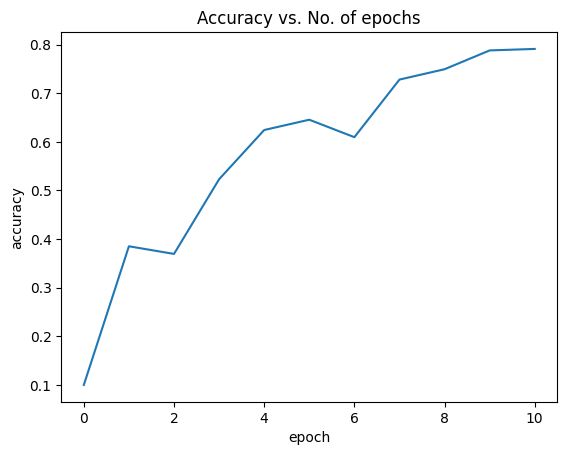

In [19]:
plot_accuracies(history)

In [20]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

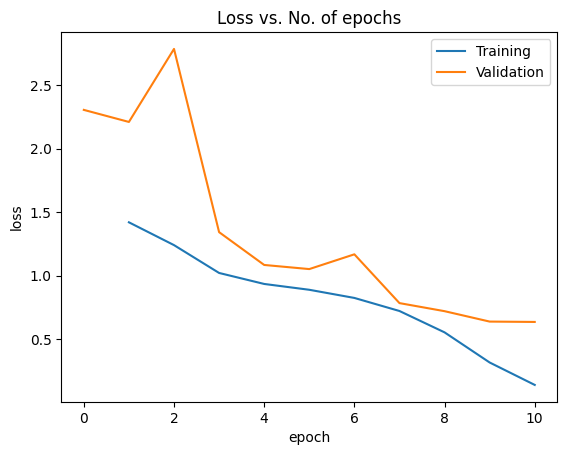

In [21]:
plot_losses(history)

In [22]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

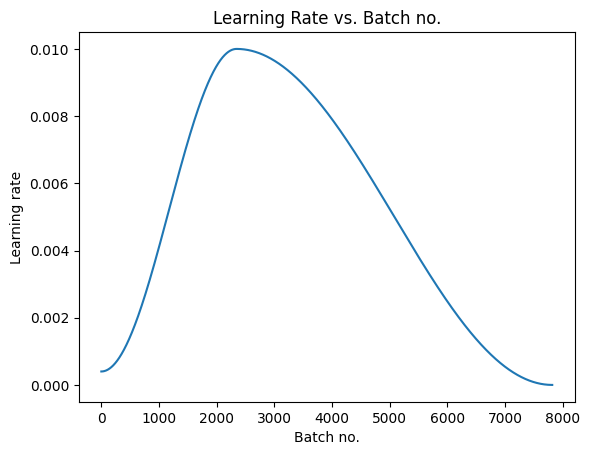

In [23]:
plot_lrs(history)

In [24]:
model.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [25]:
# # training acc
# xs = []
# ys = []
# yhats = []
# total = 0
# correct = 0
# for i in range(epochs):
#     for batch in train_loader:
#         x, y = batch[0].to(device), batch[1].to(device)
#         outputs = model(x)
#         _, predicted = torch.max(outputs.data, 1)
#         total += y.size(0)
#         correct += (predicted == y).sum().item()

#         incorrect_indices = (predicted != y).nonzero()[:, 0]
#         incorrect_samples = x[incorrect_indices,:,:,:]
#         groundTruth = y[incorrect_indices]
#         xs.append(incorrect_samples)
#         ys.append(groundTruth)
#         yhats.append ( predicted[incorrect_indices])

# accuracy = 100 * correct / total
# print(f"Accuracy: {accuracy}%")

Accuracy: 98.236%


In [26]:
torch.save(model.state_dict(), 'model_weights_encData.pth')